In [9]:
import pyMMF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.linalg import expm
from colorsys import hls_to_rgb
import pickle, os
from functions import get_disk_mask
from functions import logplotTM, get_color_map

In [10]:
DATA_PATH = './Data_18042023/'

# path to save images
IMAGE_FOLDER = './images' 
os.makedirs(IMAGE_FOLDER, exist_ok=True)

def image_path(file_name):
    return os.path.join(IMAGE_FOLDER, file_name)

In [11]:
def get_rotation_matrix(m, l, alpha):
    ''' rotation matrix in the OAM basis '''
    return np.diag(np.exp(1j*np.array(m)*alpha))

In [12]:
def colorize(z, theme = 'dark', saturation = 1., beta = 1.4, transparent = False, alpha = 1., max_threshold = 1):
    r = np.abs(z)
    r /= max_threshold*np.max(np.abs(r))
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1./(1. + r**beta) if theme == 'white' else 1.- 1./(1. + r**beta)
    s = saturation

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    if transparent:
        a = 1.-np.sum(c**2, axis = -1)/3
        alpha_channel = a[...,None]**alpha
        return np.concatenate([c,alpha_channel], axis = -1)
    else:
        return c

# Experimental data

## A. Load data

### Load parameters of the fiber

In [13]:
with open(os.path.join(DATA_PATH, 'param.pkl'), 'rb') as file:
    param = pickle.load(file, encoding='latin1')


# number of pixels in each axis in the input plane (DMD)
N_in = param['fiber']['inpoints'] 
# number of pixels in each axis in the output plane (camera)
N_out = param['fiber']['onpoints'] 
# index value at which the tip enters in contact with the fiber
contact_ind = param['Deformation']['contact_ind']
press_indices = param['Deformation']['press_indices']
# number of deformation steps
n_press = param['Deformation']['n_press']
# Values of displacement generating the deformation in microns
D_x = param['Deformation']['press_steps_treat'][press_indices]*1e3

# angles of rotation of the input wavefronts
angles = param['RME']['angles']
n_a = param['RME']['n_angles']
# number of random input wavefronts
n_rnd = param['RME']['n_rnd'] 
nv_max = param['RME']['nv_max']

# number of operatoirs
n_op = param['RME']['n_op']
# number of the first modes of each operator sent to the DMD
n_rm = param['RME']['n_rm']
n_angles_for_corr = param['RME']['n_ang_corr']

# Deformation in microns
Delta_x = np.array(param['Deformation']['steps_pressure'])[press_indices]*1e3
Delta_x -= Delta_x[0]



### Load the measured output fields corresponding to rotated inputs for different deformations 

In [14]:
!pwd

/automount/nfs/curie/promo123/spopoff/mycore/Projets/Rotational_ME


In [20]:
# experimental data using random rotating masks
Ys_rnd = np.load(os.path.join(DATA_PATH,'Ys_rnd_c64.npy'))
print(Ys_rnd.dtype)

# experimental data using for the modes of the RME operators
Ys_rm = np.load(os.path.join(DATA_PATH,'Ys_rm_c64.npy'))
print(Ys_rm.dtype)

complex64
complex64


### Load the modes

In [21]:
modes = np.load(os.path.join(DATA_PATH,'modes.npz'))
Mout = modes['modes_out'].astype(np.complex64)
m = modes['m']
l = modes['l']

### Load the TMs in the mode basis

In [22]:
TMs_mode = np.load(os.path.join(DATA_PATH,'TMs_mode.npy')).astype(np.complex64)
nmodes = TMs_mode.shape[-1]
TMs = TMs_mode[:,:nmodes, :] 

## B. Computation of angular memory effect correlation for random input wavefronts

In [23]:
# take only the input polarization corresponding to the input one
Ys_rnd_p1 = Ys_rnd[...,:N_out,:]


#### Show some output fields
Note that the field are already rotated back, i.e. $Y=\mathbf{R}(-\theta)\mathbf{T}\mathbf{R}(\theta) E^\text{rnd}_\text{in}$

/tmp/ipykernel_978211/949506782.py:7: RuntimeWarning: divide by zero encountered in true_divide
  l = 1./(1. + r**beta) if theme == 'white' else 1.- 1./(1. + r**beta)


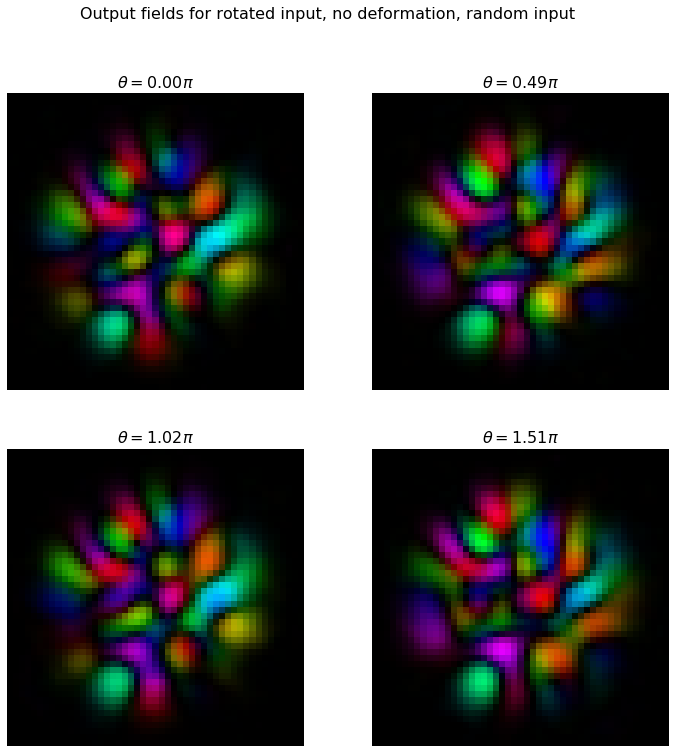

In [24]:
def get_ind_angle(angle):
    # return the index of the angle in the array of angles
    return np.argmin(np.abs(angles-angle))

angle2show = [0, np.pi/2, np.pi, 3*np.pi/2]
ind_step = 0
ind_rnd = 0

# plot the output wavefronts
plt.figure(figsize=(12, 12))
# plot each output wavefront
for i, angle in enumerate(angle2show):
    plt.subplot(2, 2, i+1)
    ind_angle = get_ind_angle(angle)
    actual_angle = angles[ind_angle]
    field = Ys_rnd_p1[ind_step, ind_angle, ind_rnd]
    plt.imshow(colorize(field))
    plt.axis('off')
    plt.title(f'$\\theta={actual_angle/np.pi:.2f}\pi$', fontsize = 16)
    plt.suptitle(
        'Output fields for rotated input, no deformation, random input',
        fontsize = 16
    )
    

In [25]:
# reshape the two last dimensions (2d output plane) into one
Ys_rnd_p1 = Ys_rnd_p1.reshape(n_press, n_a, n_rnd, N_out**2)

In [26]:
# create mask to focus on the central part of the output plane
mask_output = get_disk_mask([N_out, N_out],0.74*N_out/2).flatten().astype(np.complex64)

# apply mask to the experimental data on the last dimension
Ys_rnd_p1 = np.einsum('...i,i->...i', Ys_rnd_p1, mask_output)

# remove the average value (computed over the last dimension)
Ys_rnd_p1 -= np.mean(Ys_rnd_p1, axis=-1, keepdims=True)



In [27]:
# # # project into the mode basis 
# # It allows much smaller size, so faster computation and use less memory,
# # but could be done in the spatial basis too)
# Ys_rnd_p1_mode = np.einsum('...i,ji->...i', Ys_rnd_p1, Mout.conjugate())

In [28]:
# move the axis so that the penultimate one corresponds to angles
Ys_rnd_p1 = np.moveaxis(Ys_rnd_p1, -3, -2)

In [29]:
# reference fields, i.e. the ones we compare to
Y_rnd_ref = Ys_rnd_p1[...,0,:]

In [30]:
def stack_correlation(A,B):
    ''' compute the correlation between two stacks of images
    A and B over the last dimension
    return the correlation between the two stacks
    '''
    C = np.einsum('...jk,...k->...j', A, B.conjugate())
    Norm1 = np.einsum('...k,...k->...', A, A.conjugate())
    Norm2 = np.einsum('...k,...k->...', B, B.conjugate())
    Norm = np.sqrt(np.einsum('...k,...->...k', Norm1, Norm2.conjugate()))
    return np.abs(C/Norm)

In [31]:
Corr_rnd = stack_correlation(Ys_rnd_p1, Y_rnd_ref)

In [32]:
# Average over the realization of random inputs
Corr_rnd_avg = np.mean(Corr_rnd, axis=-2) 

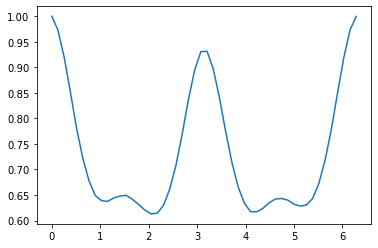

In [33]:
ind_step = 0

plt.figure()
plt.plot(angles,Corr_rnd_avg[ind_step,:])

## C. Computation of the correlation for the fiber modes

We here compute from the TM the ouput field when we send as input a mode of the perfect fiber and rotate it.

In [34]:
deformation2show## Rotation matrices for all angles of rotation
R_mats = np.array([get_rotation_matrix(m, l, a) for a in angles]).astype(np.complex64)
## All input modes one by one in the mode basis, i.e. an identity matrix
E_in = np.eye(nmodes, dtype = np.complex64)

### Compute output for each input fiber mode and each deformation


We apply rotation by an angle $\theta$ at the input plane
and by an angle $-\theta$ in the output plane, so that we have
 $Y=\mathbf{R}(-\theta)\mathbf{T}\mathbf{R}(\theta) E^\text{mode}_\text{in}$

In [35]:
# in the OAM mode basis, inverse of R = R.conjugate()
Y_modes = np.einsum('aij,sjk,akl->slai', R_mats.conjugate(), TMs[press_indices], R_mats)
Y_modes_pix = np.einsum('ijkl,lm->ijkm', Y_modes, Mout)

In [36]:
Y_modes_ref = Y_modes[...,0,:]

### Display the output field for a given input mode and deformation value

/tmp/ipykernel_978211/949506782.py:7: RuntimeWarning: divide by zero encountered in true_divide
  l = 1./(1. + r**beta) if theme == 'white' else 1.- 1./(1. + r**beta)


(-0.5, 48.5, 48.5, -0.5)

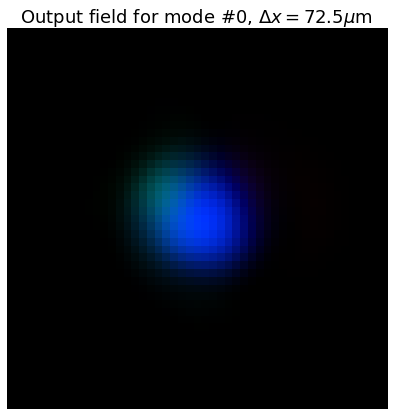

In [37]:
ind_step = -1
ind_mode = 0
plt.figure(figsize = (7,7))
plt.imshow(colorize(Y_modes_pix[ind_step, ind_mode, 0].reshape([N_out]*2)))
plt.title(
    f'Output field for mode #{ind_mode}, $\Delta x = {D_x[ind_step]:.1f}\mu$m ',
    fontsize = 18,
)
plt.axis('off')

### Compute correlation between all angles and angle = 0 for all the parameters

In [38]:
Corr_modes = stack_correlation(Y_modes, Y_modes_ref)

### Show the RME correlation for different deformation and different input modes

/tmp/ipykernel_978211/949506782.py:7: RuntimeWarning: divide by zero encountered in true_divide
  l = 1./(1. + r**beta) if theme == 'white' else 1.- 1./(1. + r**beta)


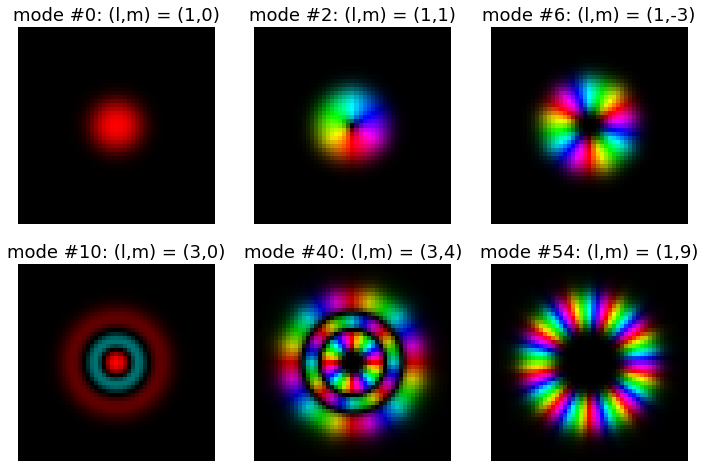

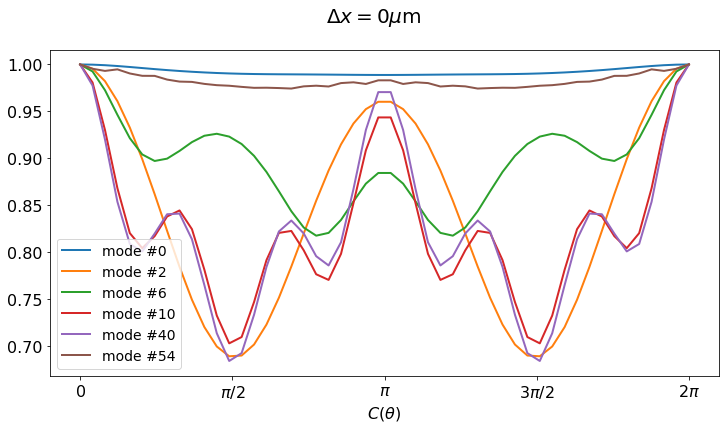

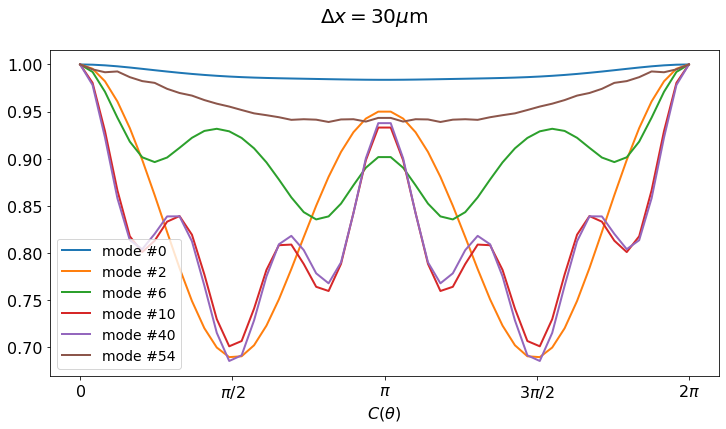

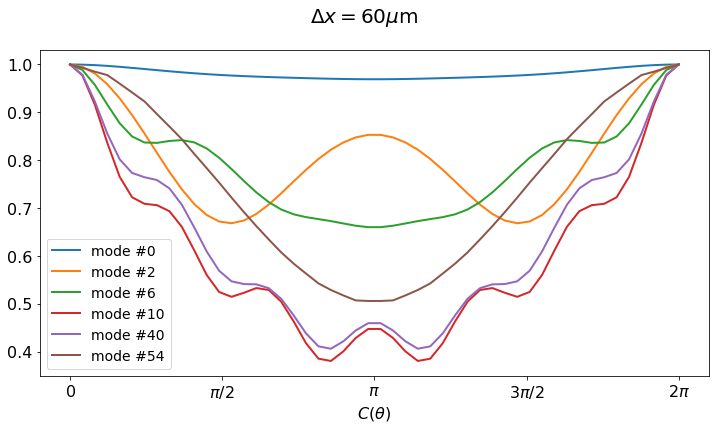

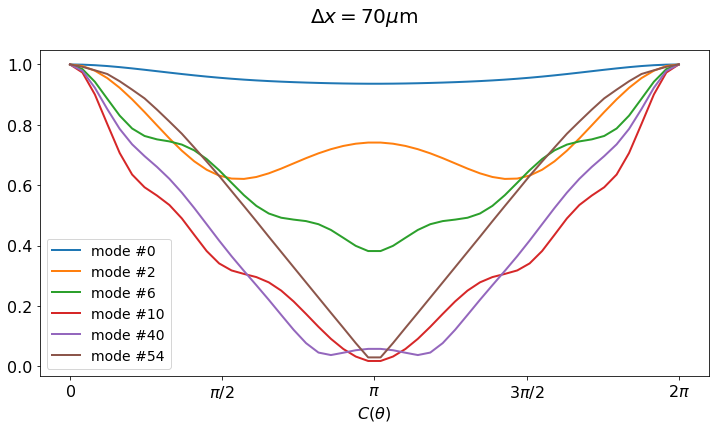

In [39]:
modes2show = [0,2,6,10, 40, 54]


plt.figure(figsize = (12,8))
for i, ind_mode in enumerate(modes2show):
    plt.subplot(2, 3,i+1)
    plt.imshow(colorize(Mout[ind_mode].reshape([N_out]*2)))
    plt.axis('off')
    plt.title(
        f'mode #{ind_mode}: (l,m) = ({l[ind_mode]},{m[ind_mode]})',
        fontsize =18
    )



def show_RME_modes(ind_deformation):
    plt.figure(figsize = (12,6))
    for ind_mode in modes2show:
        plt.plot(
            angles,
            Corr_modes[ind_deformation,ind_mode,:], 
            linewidth = 2,
            label = f'mode #{ind_mode}'
        )
    plt.xlabel(r'$\theta$', fontsize = 16)
    plt.xlabel(r'$C(\theta)$', fontsize = 16)
    xticks = [0,np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    xtics_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    plt.xticks(xticks, xtics_labels, fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(fontsize = 14)
    plt.suptitle(
        f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
        fontsize = 20
    )

show_RME_modes(ind_deformation = 0)
show_RME_modes(ind_deformation = 12)
show_RME_modes(ind_deformation = 24)
show_RME_modes(ind_deformation = -2)



#### Show the minimum of the correlation curve for each mode for different deformations

Text(0.5, 1.0, 'RME efficiency of the fibers modes')

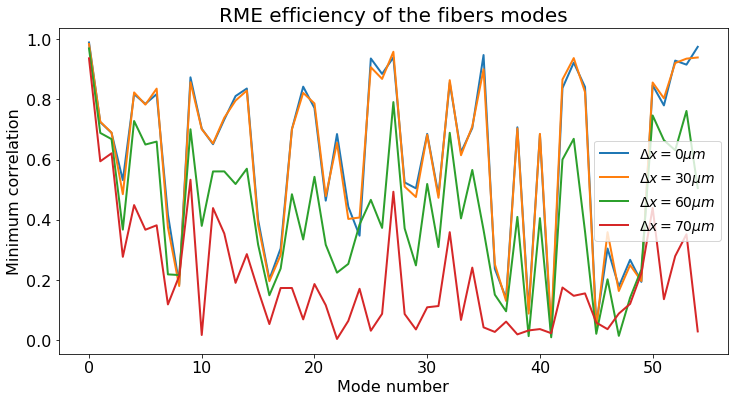

In [40]:
min_Corr_modes = np.min(Corr_modes, axis = -1)

deformation2show = [0,12,24,-2]



plt.figure(figsize = (12,6))
for i, ind_deformation in enumerate(deformation2show):    
    plt.plot(
        min_Corr_modes[ind_deformation], 
        label = rf'$\Delta x = {D_x[ind_deformation]:.0f}\mu m$',
        linewidth = 2
    )
plt.xlabel('Mode number', fontsize = 16)
plt.xticks(fontsize = 16)
plt.ylabel('Minimum correlation', fontsize = 16)
plt.yticks(fontsize = 16)

plt.xticks(fontsize = 16)
plt.legend(fontsize = 14)
plt.title('RME efficiency of the fibers modes', fontsize = 20)

# RME Operator

## Computation of correlation for the modes of the RME operators

**Operators:** $\mathbf{O}(\theta) = \mathbf{T}^\dagger\mathbf{R(\theta)}^\dagger\mathbf{T}\mathbf{R(\theta)}$
1.  $\mathbf{O}(\theta = \pi/4)$

In [41]:
# take polarization identical to the one of the input
# + transform the two spatial (last) dimensions into one
Ys_rm_p1 = Ys_rm[..., :N_out, :].reshape(n_press, n_op, n_a, n_rm, N_out**2)
Ys_rm_p1 = np.moveaxis(Ys_rm_p1, -3, -2)

`Ys_rm`: [deformation $\times$ operator $\times$ mode $\times$ angles $\times$ Nx $\times$ Ny]

In [42]:
Ys_rm_ref = Ys_rm_p1[...,0,:]


In [43]:
Corr_rnd = stack_correlation(Ys_rm_p1, Ys_rm_ref)

In [44]:
label_operators = [
    r'$\hat O_{corr} (\pi /2) $' , 
    r'$\hat O_{corr} (3\pi /2) $', 
    r'$\sum \hat O_{corr} $',
    r'$\hat O_{comm} (\pi /2) $' , 
    r'$\hat O_{comm} (3\pi /2) $'
]

def generate_color_shades(color, n):
    # Generate a list of `n` different shades of the given color
    cmap = plt.get_cmap(color)
    dc = 100
    shades = [cmap(int(dc + i * (255 - dc) / (n - 1))) for i in range(n)]
    return shades[::-1]

n = 4  # Number of shades

# Generate lists of shades for blue, red, and green
shades = [
    generate_color_shades('PuRd', n),
    generate_color_shades('Blues', n),
    generate_color_shades('Greens', n)
]

def show_RME_operator(ind_deformation, inds_operator, inds_mode, save_fig = True):
    plt.figure(figsize = (12,6))
    label_size = 22

    # plot the modes of the correlation operators
    for i_operator, ind_operator in enumerate(inds_operator):
        for i_mode, ind_mode in enumerate(inds_mode):
            plt.plot(
                angles,
                Corr_rnd[ind_deformation, ind_operator, ind_mode,:], 
                linewidth = 2,
                label = f'{label_operators[ind_operator]} #{ind_mode+1}',
                c = shades[i_operator][i_mode]
            )

    # plot the random inputs
    ind_mode = 0
    plt.plot(
        angles,
        Corr_rnd_avg[ind_deformation,:], 
        'r--',
        linewidth = 2,
        label = f'random inputs',
    )

    # plot average for fundamental mode
    ind_mode = 0
    plt.plot(
        angles,
        Corr_modes[ind_deformation, ind_mode,:], 
        'k--',
        linewidth = 2,
        label = 'fundamental mode',
    )

    plt.grid()
    plt.xlabel(r'$\theta$', fontsize = label_size)
    plt.ylabel(r'$C(\theta)$', fontsize = label_size)
    xticks = [0,np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
    xtics_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
    plt.xticks(xticks, xtics_labels, fontsize = label_size)
    plt.yticks(fontsize = label_size)
    plt.legend(fontsize = 14)
    plt.suptitle(
        f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
        fontsize = 20
    )

    if save_fig:
        plt.savefig(
            image_path(f'Corr_rnd_{D_x[ind_deformation]:.0f}um.svg'),
            dpi = 300,
        )

In [45]:
def show_operator_modes(ind_deformation, operators, ind_modes, save_fig = True):
    plt.figure(figsize = (7,7))
    ind_mode = ind_modes[0]
    ind_angle = 0
    theme = 'white'
    toimg = lambda A: colorize(A, theme = theme, alpha = 0.)
    plt.subplot(221)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[0], ind_angle, ind_mode,:N_out,:]))
    plt.title(f'{label_operators[operators2show[0]]} #{ind_mode+1}')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[1], ind_angle, ind_mode,:N_out,:]))
    plt.title(f'{label_operators[operators2show[1]]} #{ind_mode+1}')
    plt.axis('off')
    ind_mode = ind_modes[1]
    plt.subplot(223)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[0], ind_angle, ind_mode,:N_out,:]))
    plt.title(f'{label_operators[operators2show[0]]} #{ind_mode+1}')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[1], ind_angle, ind_mode,:N_out,:]))
    plt.title(f'{label_operators[operators2show[1]]} #{ind_mode+1}')
    plt.axis('off')

    if save_fig:
        plt.savefig(
            image_path(f'RME_modes_{D_x[ind_deformation]:.0f}um.svg'),
            dpi = 300,
        )

/tmp/ipykernel_978211/949506782.py:7: RuntimeWarning: divide by zero encountered in true_divide
  l = 1./(1. + r**beta) if theme == 'white' else 1.- 1./(1. + r**beta)


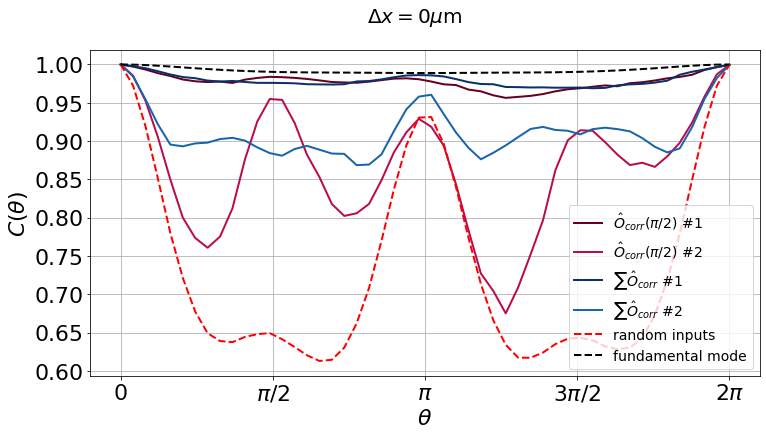

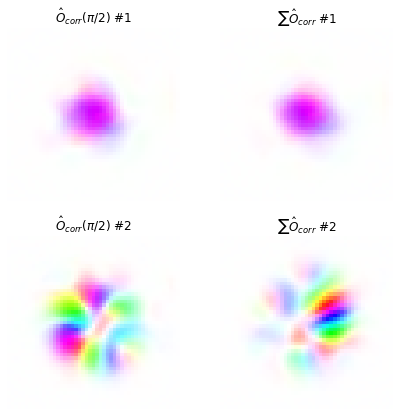

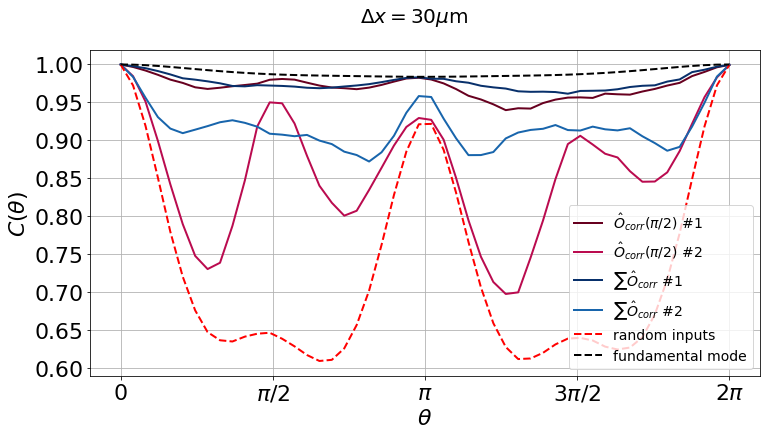

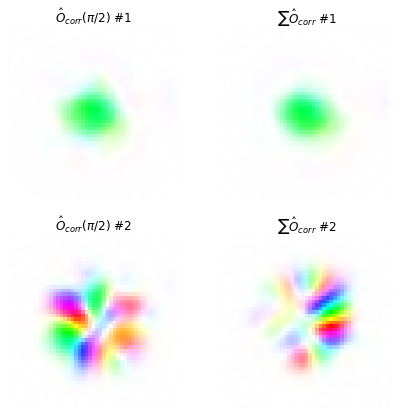

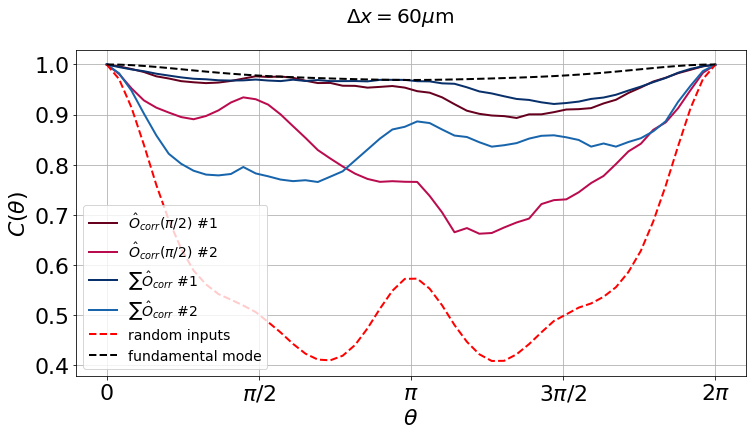

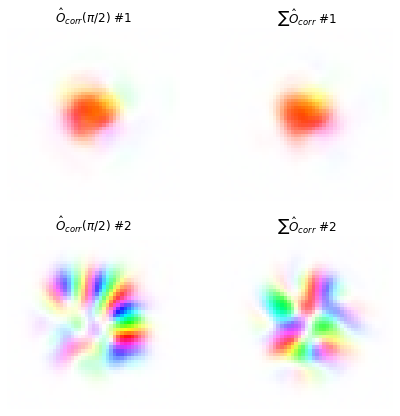

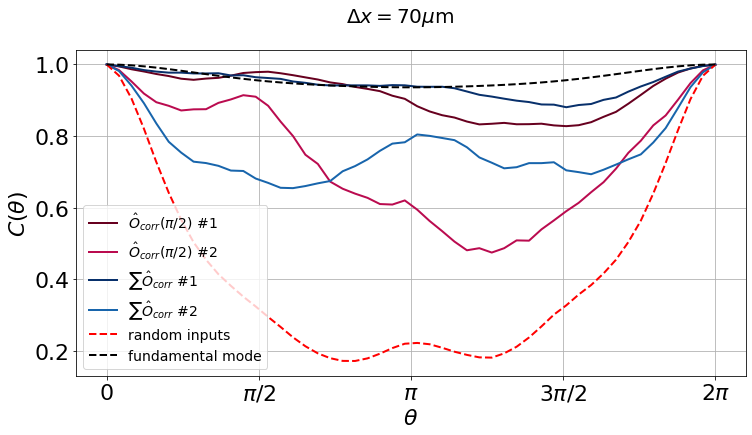

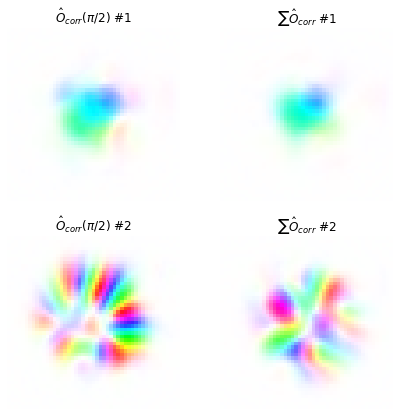

In [46]:
operators2show = [0, 2]
modes2show = [0,1]
ind_angle = 0
ind_deformation, ind_operator, ind_mode = 0, 0, 0
for ind_deformation in deformation2show:
    show_RME_operator(
        ind_deformation, 
        operators2show, 
        modes2show,
    )
    
    show_operator_modes(
        ind_deformation,
        operators2show[0:2],
        modes2show[0:2],
    )

### Autocorrelation of the RME channels

$$
C_0(\theta) =  
    \left|
    \frac{
        \bra{\phi}\mathbf{T}^\dagger\mathbf{R(\theta)}^\dagger\mathbf{T}\ket{\phi}
    }{
            \bra{\phi}\mathbf{T}^\dagger\mathbf{T}\ket{\phi}        
    }
    \right|
$$

In [47]:
# fix the input rotation angle
ind_angle = 0
Ys_rm0 = Ys_rm_p1[...,ind_angle, :]
# project into mode basis
Ys_rm0_mode = np.einsum('ij,...j->...i', Mout.conjugate(), Ys_rm0)
# rotate the patterns
Ys_rm0_mode_rot = np.einsum('aij,...j->...ai', R_mats, Ys_rm0_mode)
Ys_rm_autocorr_ref = Ys_rm0_mode_rot[...,0,:]

In [48]:
def get_autocorr(Y0_mode):
    ind_angle = 0
    Y0_mode = Y0_mode[...,ind_angle, :]
    # project into mode basis
    # Y0_mode = np.einsum('ij,...j->...i', Mout.conjugate(), Y0)
    # rotate the patterns
    Y0_rot = np.einsum('aij,...j->...ai', R_mats, Y0_mode)
    Y0_autocorr_ref = Y0_rot[...,0,:]
    Autocorr_op = stack_correlation(Y0_rot, Y0_autocorr_ref)
    return Autocorr_op

In [49]:
# project into mode basis
Ys_rm_mode = np.einsum('ij,...j->...i', Mout.conjugate(), Ys_rm_p1)

In [50]:
Autocorr_op = get_autocorr(Ys_rm_mode)
Autocorr_modes = get_autocorr(Y_modes)

In [63]:
# def show_autocorr(ind_deformation, operators2show, ind_angle, modes2show, save_fig = True):
#     label_size = 22
#     plt.figure(figsize = (14,5))
#     for i_operator, ind_operator in enumerate(operators2show):
#         for i_mode, ind_mode in enumerate(modes2show):
#             plt.subplot(1, len(operators2show), i_operator+1)
#             plt.plot(
#                 np.abs(Mode_proj[ind_deformation, ind_operator, ind_angle, ind_mode,:])**2,
#                 color = shades[0][i_mode],
#                 label = f'Mode #{ind_mode+1}',
#                 marker = 'o',
#             )
#             plt.legend(fontsize = 16)
#             plt.xticks(fontsize = label_size)
#             plt.xlabel('Mode index', fontsize = label_size+2)
#             plt.yticks(fontsize = label_size)
#             plt.ylabel(r'$C_0(\theta)$', fontsize = label_size+2)
#             plt.title(f'Operator {label_operators[ind_operator]}', fontsize = label_size+2)
#     plt.suptitle(
#         f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
#         fontsize = label_size+6,
#         y=1.1
#     )

#     plt.tight_layout()
#     if save_fig:
#         plt.savefig(
#             image_path(f'Proj_op_channels_{D_x[ind_deformation]:.0f}um.svg'),
#             dpi = 300,
#         )

/tmp/ipykernel_978211/884259845.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, len(operators2show), i_operator+1)


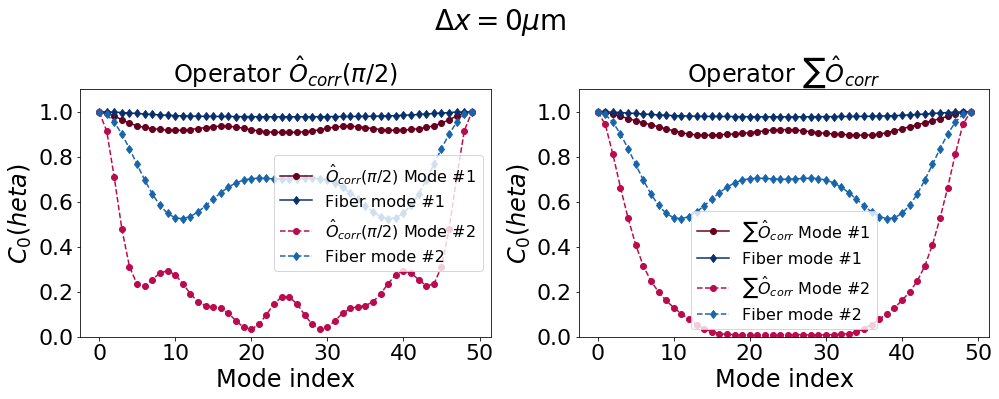

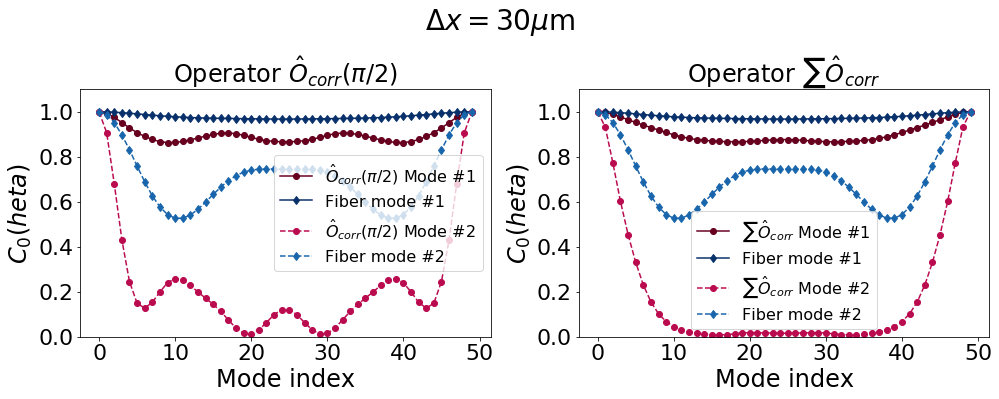

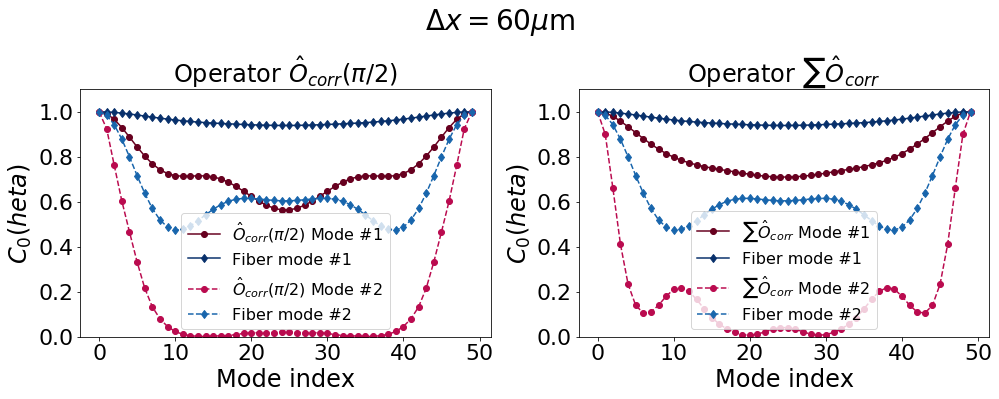

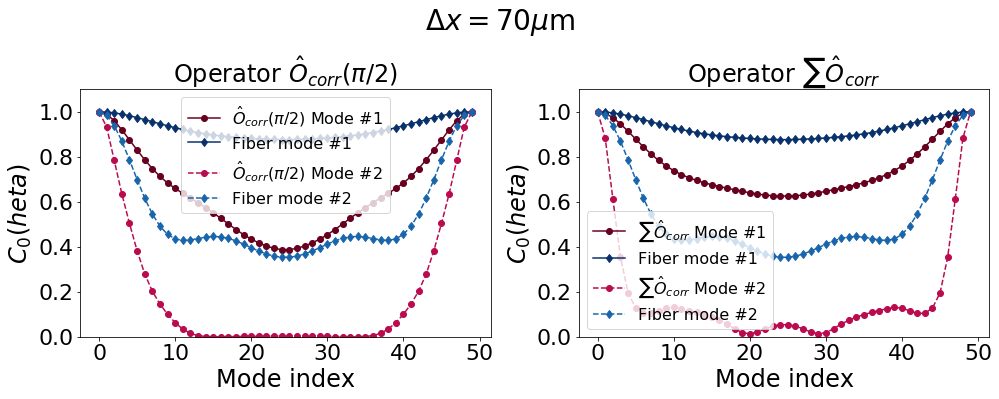

In [64]:
ind_deformation = 0
ind_operator = 0
ind_op_mode = 1
ind_fiber_mode = 0

linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
# plt.figure(figsize=(12,8))
# plt.plot(angles, Autocorr_op[ind_deformation, ind_operator, ind_op_mode])
# plt.plot(angles, Autocorr_modes[ind_deformation, ind_fiber_mode], 'r--')

def show_autocorr(ind_deformation, operators2show, ind_angle, modes2show, save_fig = True):
    label_size = 22

    plt.figure(figsize = (14,5))
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):
            plt.subplot(1, len(operators2show), i_operator+1)
            plt.plot(
                np.abs(Autocorr_op[ind_deformation, ind_operator, ind_mode,:])**2,
                color = shades[0][i_mode],
                label = f'{label_operators[ind_operator]} Mode #{ind_mode+1}',
                marker = 'o',
                linestyle=linestyles[i_mode],
            )
            plt.plot(
                np.abs(Autocorr_modes[ind_deformation, ind_mode,:])**2,
                color = shades[1][i_mode],
                label = f'Fiber mode #{ind_mode+1}',
                marker = 'd',
                linestyle=linestyles[i_mode],
            )
            plt.ylim([0,1.1])
            plt.legend(fontsize = 16)
            plt.xticks(fontsize = label_size)
            plt.xlabel('Mode index', fontsize = label_size+2)
            plt.yticks(fontsize = label_size)
            plt.ylabel(r'$C_0(\theta)$', fontsize = label_size+2)
            plt.title(f'Operator {label_operators[ind_operator]}', fontsize = label_size+2)

        plt.suptitle(
        f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
        fontsize = label_size+6,
        y=1.1
    )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f'Autocorr_op_channels_{D_x[ind_deformation]:.0f}um.svg'),
            dpi = 300,
        )


for ind_deformation in deformation2show:
    show_autocorr(
        ind_deformation, 
        operators2show, 
        ind_angle, 
        modes2show,
    )


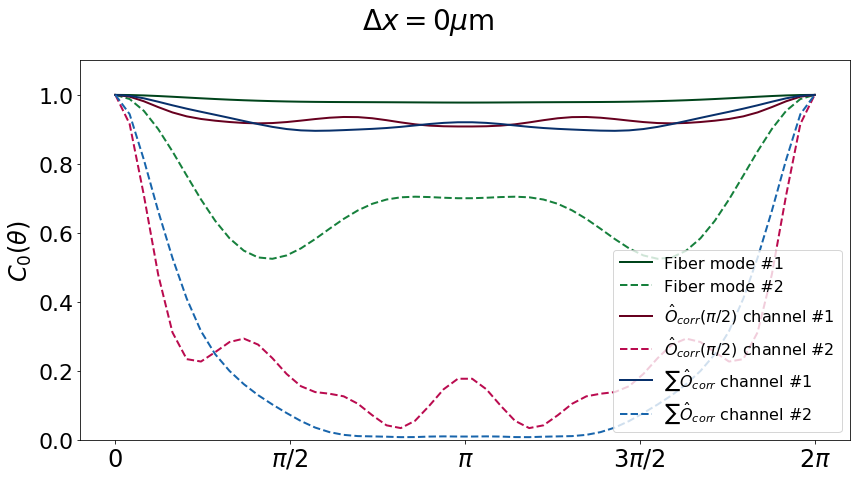

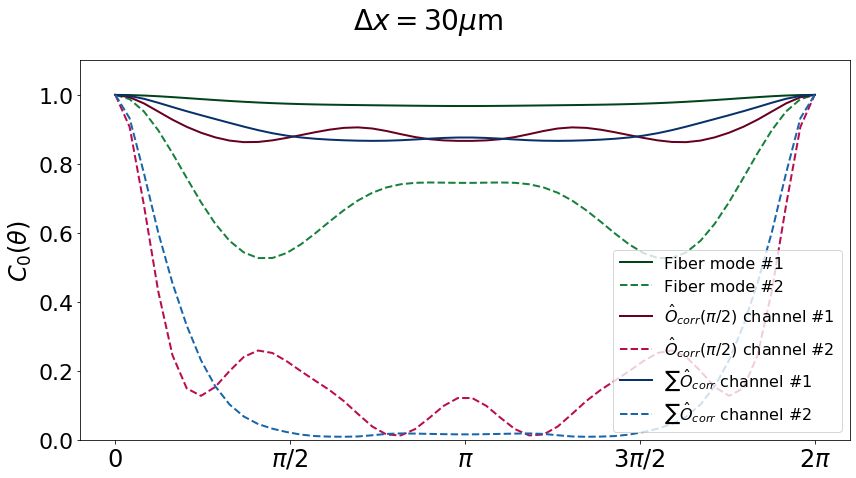

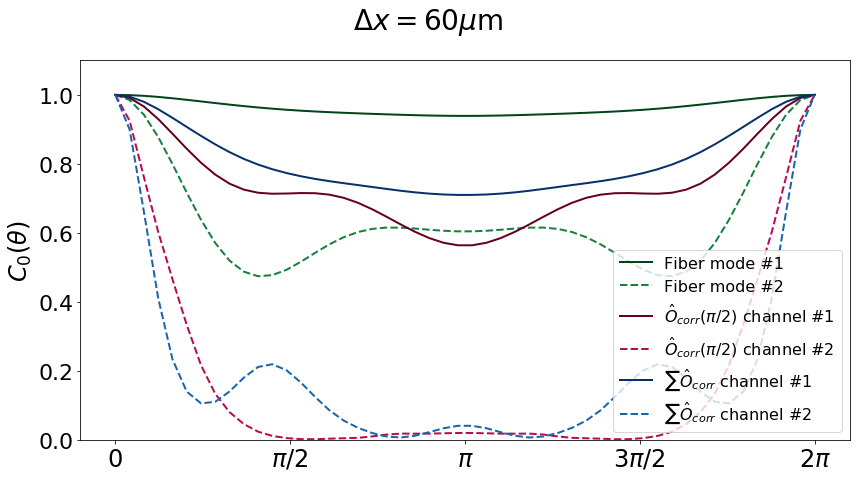

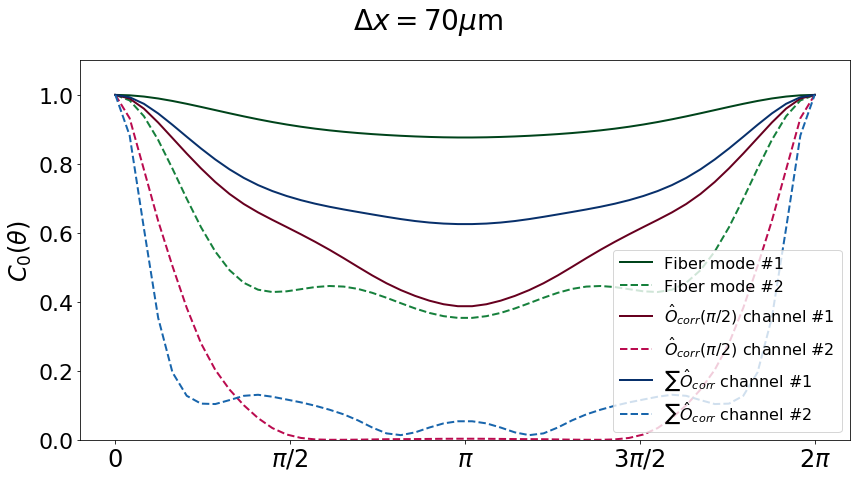

In [72]:
ind_deformation = 0
ind_operator = 0
ind_op_mode = 1
ind_fiber_mode = 0

linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
# plt.figure(figsize=(12,8))
# plt.plot(angles, Autocorr_op[ind_deformation, ind_operator, ind_op_mode])
# plt.plot(angles, Autocorr_modes[ind_deformation, ind_fiber_mode], 'r--')

def show_autocorr(ind_deformation, operators2show, ind_angle, modes2show, save_fig = True):
    label_size = 22

    plt.figure(figsize = (12,6))
    for i_mode, ind_mode in enumerate(modes2show):
        
        
            plt.plot(
                angles,
                np.abs(Autocorr_modes[ind_deformation, ind_mode,:])**2,
                color = shades[2][i_mode],
                label = f'Fiber mode #{ind_mode+1}',
                # marker = 'd',
                linestyle=linestyles[i_mode],
                linewidth = 2,
            )
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):
        
            plt.plot(
                angles,
                np.abs(Autocorr_op[ind_deformation, ind_operator, ind_mode,:])**2,
                color = shades[i_operator][i_mode],
                label = f'{label_operators[ind_operator]} channel #{ind_mode+1}',
                # marker = 'o',
                linestyle=linestyles[i_mode],
                linewidth = 2,
            )
            
            plt.ylim([0,1.1])
            plt.legend(
                fontsize = 16,
                loc = 'lower right')
            xticks = [0,np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
            xtics_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
            plt.xticks(xticks, xtics_labels, fontsize = label_size+2)
            plt.yticks(fontsize = label_size)
            plt.ylabel(r'$C_0(\theta)$', fontsize = label_size+2)
            # plt.title(f'Operator {label_operators[ind_operator]}', fontsize = label_size+2)

        plt.suptitle(
            f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
            fontsize = label_size+6,
            y=1.1
        )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f'Autocorr_op_channels_{D_x[ind_deformation]:.0f}um.svg'),
            dpi = 300,
        )


for ind_deformation in deformation2show:
    show_autocorr(
        ind_deformation, 
        operators2show, 
        ind_angle, 
        modes2show,
    )


### Projection in the mode basis

In [54]:
ind_deformation = 0
operators2show = [0, 2]
modes2show = [0,1]
ind_angle = 0

Mode_proj = np.abs(
    np.einsum(
        'ij,...j->...i', 
        Mout.conjugate(), 
        Ys_rm[...,:N_out,:].reshape(list(Ys_rm.shape[:-2])+[N_out**2]) # flatten the last two spatial dimensions
    )
)
# normalize the projection
Mode_proj = Mode_proj/np.linalg.norm(Mode_proj, axis = -1)[...,None]

In [55]:
Ys_rm.shape

(30, 5, 50, 5, 98, 49)

In [56]:
list(Ys_rm[...,:N_out,:].shape[:-2])+[N_out**2]

[30, 5, 50, 5, 2401]

In [ ]:
A = Ys_rm[...,:N_out,:].reshape(list(Ys_rm.shape[:-2])+[N_out**2])
proj2 = np.abs(A@Mout.conjugate().transpose())

In [ ]:
Mode_prj = np.abs(Mout.conjugate()@Channel)
Mode_prj /= np.linalg.norm(Mode_prj)

NameError: name 'Channel' is not defined

In [ ]:
ind_deformation = 0
ind_operator = 0
ind_angle = 0
ind_mode = 0

modes2show = [0,1,4]
operators2show = [0, 2]

n = int(len(modes2show)*1.75)
shades = [
    generate_color_shades('PuRd', n),
    generate_color_shades('Blues', n),
    generate_color_shades('Greens', n)
]

def show_projection(ind_deformation, operators2show, ind_angle, modes2show, save_fig = True):
    label_size = 22
    plt.figure(figsize = (14,5))
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):
            plt.subplot(1, len(operators2show), i_operator+1)
            plt.plot(
                np.abs(Mode_proj[ind_deformation, ind_operator, ind_angle, ind_mode,:])**2,
                color = shades[0][i_mode],
                label = f'Mode #{ind_mode+1}',
                marker = 'o',
            )
            plt.legend(fontsize = 16)
            plt.xticks(fontsize = label_size)
            plt.xlabel('Mode index', fontsize = label_size+2)
            plt.yticks(fontsize = label_size)
            plt.ylabel('Projection coefficients', fontsize = label_size+2)
            plt.title(f'Operator {label_operators[ind_operator]}', fontsize = label_size+2)
    plt.suptitle(
        f'$\Delta x = {D_x[ind_deformation]:.0f} \mu$m',
        fontsize = label_size+6,
        y=1.1
    )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f'Proj_op_channels_{D_x[ind_deformation]:.0f}um.svg'),
            dpi = 300,
        )

for ind_deformation in deformation2show:
    show_projection(
        ind_deformation, 
        operators2show, 
        ind_angle, 
        modes2show,
    )
# show_projection(ind_deformation, operators2show, ind_angle, modes2show)

In [ ]:
STOP

In [ ]:
# ind_2_plot = [0,8,16,24]
# op_to_show = np.arange(n_op)
op_to_show = [0,2]
n_op = len(op_to_show)
ind_2_plot = [3,12,21,29]
inds_mode = [0,1]
# cmap = get_color_map(len(ind_2_plot))
line_cmap = matplotlib.cm.get_cmap('viridis')
color_list = [line_cmap(0+i/(n_op)) for i in range(n_op)]
lbl_list = [r'$\hat O_{corr} (\pi /2) $' , 
            r'$\hat O_{corr} (3\pi /2) $', 
            r'$\hat O_{corr} (\pi/4,\pi /2,3\pi/4,5\pi/4 ,3\pi /2,7\pi/4) $',
            r'$\hat O_{comm} (\pi /2) $' , 
            r'$\hat O_{comm} (3\pi /2) $']

fig, axs = plt.subplots(2,2,figsize = (12,9))


for ind_mode in inds_mode:
    for ind_p, ax in enumerate(axs.ravel()):
        for i, op in enumerate(op_to_show):
            ax.plot(angles,np.abs(Corr_rnd[ind_2_plot[ind_p],op,ind_mode]),c=color_list[i], label=lbl_list[op])
        ax.plot(angles,Corr_rnd_avg[ind_2_plot[ind_p]],'r--')
        ax.set_title(rf'$\Delta x = {Delta_x[ind_p]:.2f}\mu m$', fontsize = 16)
   
for ind_p, ax in enumerate(axs.ravel()):
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],0]),'r--')
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],1]),'r--')
    ax.plot(angles,np.abs(Corr_modes[ind_2_plot[ind_p],4]),'r--')
    

# axs[0,0].legend(prop={'size': 10})
for i in range(2):
    axs[1,i].set_xlabel(r'rotation angle $\theta$', fontsize=16)
    axs[i,0].set_ylabel('Correlation', fontsize=16)

xticks = [0,np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
xtics_labels = [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$']
for ax in axs.ravel():
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xticks(ticks = xticks)
    ax.set_xticklabels(xtics_labels, fontsize = 16)
    ax.set_ylim([0.5,1])
    ax.grid()
ax.set_ylim([0.1,1])

formula = r'$\left\|C(\mathbf{T}\left|\psi\right\rangle,\mathbf{R}^{-1}\mathbf{T}\mathbf{R}\left|\psi\right\rangle)\right|$'
plt.suptitle(formula, fontsize = 16)

fig.savefig(image_path('rot_modes_deform.svg'),bbox_inches='tight')

In [ ]:
ind_step = 0
ind_op = 2
ind_mode = 1
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(colorize(Ys_rm[ind_step, ind_op,0,ind_mode,:N_out,:]))
plt.axis('off')
plt.title(rf'$\theta=0$', fontsize = 16)
plt.subplot(222)
plt.imshow(colorize(Ys_rm[ind_step, ind_op,n_a//4,ind_mode,:N_out,:]))
plt.axis('off')
plt.title(rf'$\theta=\pi/2$', fontsize = 16)
plt.subplot(223)
plt.imshow(np.abs(Ys_rm[ind_step, ind_op,0,ind_mode,:N_out,:])**2)
plt.axis('off')
plt.title(rf'$\theta=0$', fontsize = 16)
plt.subplot(224)
plt.imshow(np.abs(Ys_rm[ind_step, ind_op,n_a//4,ind_mode,:N_out,:])**2)
plt.axis('off')
plt.title(rf'$\theta=\pi/2$', fontsize = 16)
plt.suptitle(lbl_list[ind_op]+ rf', #{ind_mode},  $\Delta x={Delta_x[ind_step]:.2f}\mu m$', y = 1.05, fontsize = 16);
# plt.tight_layout(pad =20)

In [ ]:
list(modes.keys())

In [ ]:
E_in

In [ ]:
ind_mode = 4

TM = TMs[ind_p]
E_in = modes['modes_in_corr'][ind_mode].reshape([30]*2)

plt.figure()
plt.imshow(colorize(E_in))

In [ ]:
TM.shape

In [ ]:
mask_corr = get_disk_mask([N_out, N_out],0.74*N_out/2)
mode_corr_p1 = np.zeros((n_press, n_a, n_rnd),complex)
for step, Ystep in tqdm(enumerate(Ys_rnd)):
    for ind, Yrnd in enumerate(np.moveaxis(Ystep,1,0)):
        rnd_corr_p1[step,:,ind] = mode_corr_p1(Yrnd[...,:N_out,:].reshape(n_a,-1), remove_mean=True, mask=mask_corr)
Corr_mean_exp = np.mean(np.abs(mode_corr_p1),axis=-1)